In [1]:
import pandas as pd

import tensorflow as tf
from kerastuner.tuners import RandomSearch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import yfinance as yf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

C:\Users\Denis\AppData\Local\Temp/ipykernel_3336/1916523580.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
df = yf.download('^GSPC', start='2008-01-01', end='2023-08-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
features_considered = ['Close', 'Volume']

In [6]:
features = df[features_considered]
features.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [8]:
features.tail()

,Close,Volume
Date,,
2023-07-25,4567.459961,3812470000
2023-07-26,4566.750000,3990290000
2023-07-27,4537.410156,4553210000
2023-07-28,4582.229980,3981010000
2023-07-31,4588.959961,4503600000


In [10]:
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import numpy as np


def build_model(hp):
    input_shape = (x_train_multi.shape[1], x_train_multi.shape[2])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(hp.Int('units_1', min_value=16, max_value=256, step=16),
                                   return_sequences=True,
                                   input_shape=input_shape))
    model.add(tf.keras.layers.LSTM(hp.Int('units_2', min_value=16, max_value=128, step=16), activation='relu'))
    model.add(tf.keras.layers.Dense(future_target))
    

    optimizer = tf.keras.optimizers.RMSprop(clipvalue=1.0, learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='mae')
    return model


def prepare_data(dataset, past_history, future_target, train_split):
    data_mean = dataset[:train_split].mean(axis=0)
    data_std = dataset[:train_split].std(axis=0)
    dataset = (dataset - data_mean) / data_std

    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                     train_split, past_history, future_target)
    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                                 train_split, None, past_history, future_target)
    return x_train_multi, y_train_multi, x_val_multi, y_val_multi


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


past_history = 21
future_target = 5
num_features = 2
EPOCHS = 20 

total_records = len(features)
TRAIN_SPLIT = int(0.8 * total_records)
print("TRAIN_SPLIT:", TRAIN_SPLIT)


dataset = features.values


x_train_multi, y_train_multi, x_val_multi, y_val_multi = prepare_data(dataset, past_history, future_target, TRAIN_SPLIT)


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10, 
    directory='my_tuner_dir',  
    project_name='my_multi_step_model')


tuner.search(x_train_multi, y_train_multi, epochs=EPOCHS, validation_data=(x_val_multi, y_val_multi))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Лучшие гиперпараметры:", best_hyperparameters)

best_model_history = best_model.fit(x_train_multi, y_train_multi, epochs=EPOCHS,
                                    validation_data=(x_val_multi, y_val_multi), verbose=1)

print("История обучения лучшей модели:", best_model_history.history)

Trial 10 Complete [00h 05m 51s]
val_loss: 0.12609440088272095

Best val_loss So Far: 0.12609440088272095
Total elapsed time: 00h 23m 21s
INFO:tensorflow:Oracle triggered exit
Лучшие гиперпараметры: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000020C98F20940>
Epoch 1/20
98/98 [==============================] - 22s 169ms/step - loss: 0.0649 - val_loss: 0.2030
Epoch 2/20
98/98 [==============================] - 18s 183ms/step - loss: 0.0630 - val_loss: 0.5219
Epoch 3/20
98/98 [==============================] - 17s 177ms/step - loss: 0.0606 - val_loss: 0.2235
Epoch 4/20
98/98 [==============================] - 17s 170ms/step - loss: 0.0596 - val_loss: 0.3172
Epoch 5/20
98/98 [==============================] - 17s 171ms/step - loss: 0.0574 - val_loss: 0.2077
Epoch 6/20
98/98 [==============================] - 17s 176ms/step - loss: 0.0561 - val_loss: 0.2103
Epoch 7/20
98/98 [==============================] - 18s 185ms/step - loss: 0.0551 - val_loss: 0.39

In [11]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

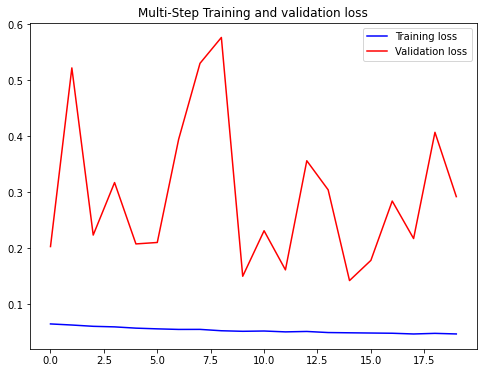

In [12]:
plot_train_history(best_model_history, 'Multi-Step Training and validation loss')

1/1 [==============================] - 1s 1s/step


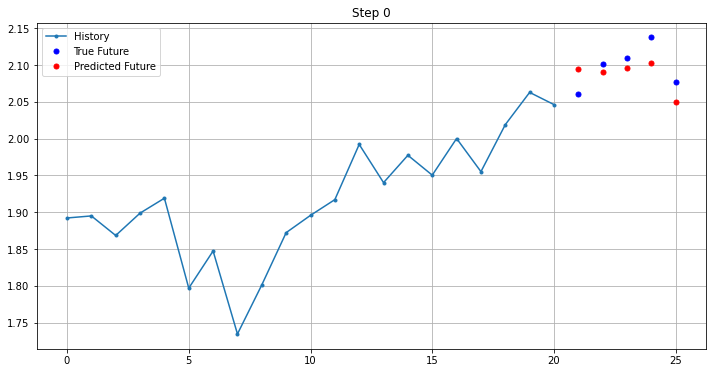

1/1 [==============================] - 0s 31ms/step


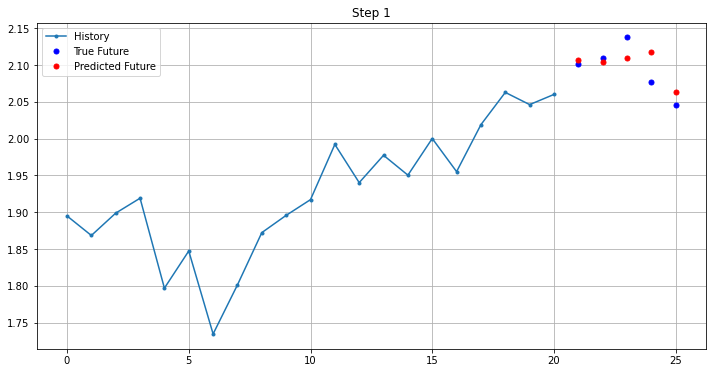

1/1 [==============================] - 0s 50ms/step


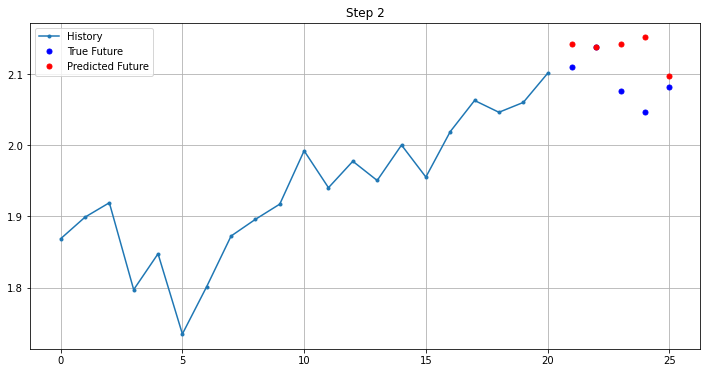

In [13]:
def plot_multi_step(history, true_future, prediction, step):
    plt.figure(figsize=(12, 6))
    num_in = np.arange(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history[:, 0], label='History', marker='.', zorder=2)

    plt.plot(np.arange(num_out) + num_in[-1] + 1, true_future, 'bo', label='True Future', markersize=5, zorder=2)

    plt.plot(np.arange(num_out) + num_in[-1] + 1, prediction, 'ro', label='Predicted Future', markersize=5, zorder=2)

    plt.legend(loc='upper left')
    plt.title(f'Step {step}')
    plt.grid(True)
    plt.show()

for step in range(3):
    plot_multi_step(x_val_multi[step], y_val_multi[step], best_model.predict(x_val_multi[step:step+1])[0], step)


Prediction:

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np

ticker_symbol = "^GSPC"
end_date = "2023-09-15"  

start_date = pd.to_datetime(end_date) - pd.DateOffset(days=21)


data = yf.download(ticker_symbol, start=start_date, end=end_date)


selected_features = data[["Close", "Volume"]]


last_21_days = selected_features.values

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

normalized_last_21_days = (last_21_days - data_mean) / data_std

forecast = best_model.predict(np.array([normalized_last_21_days]))

forecast_unscaled = []

for i in range(forecast.shape[1]):
    single_day_forecast = forecast[0, i]  
    unscaled_forecast = single_day_forecast * data_std + data_mean
    forecast_unscaled.append(unscaled_forecast)

for i, forecast_value in enumerate(forecast_unscaled):
    print(f"Forecast for the day {i+1}:")
    print(f"Close: {forecast_value[0]}")
    print(f"Volume: {forecast_value[1]}")
    print("------------------------")


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 37ms/step
Forecast for the day 1:
Close: 4491.054931388927
Volume: 3562657037.7787595
------------------------
Forecast for the day 2:
Close: 4489.357761698706
Volume: 3551710029.87792
------------------------
Forecast for the day 3:
Close: 4490.315855366837
Volume: 3557889882.7324753
------------------------
Forecast for the day 4:
Close: 4488.964950317515
Volume: 3549176335.5053344
------------------------
Forecast for the day 5:
Close: 4490.826638614738
Volume: 3561184513.9544487
------------------------


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 44ms/step


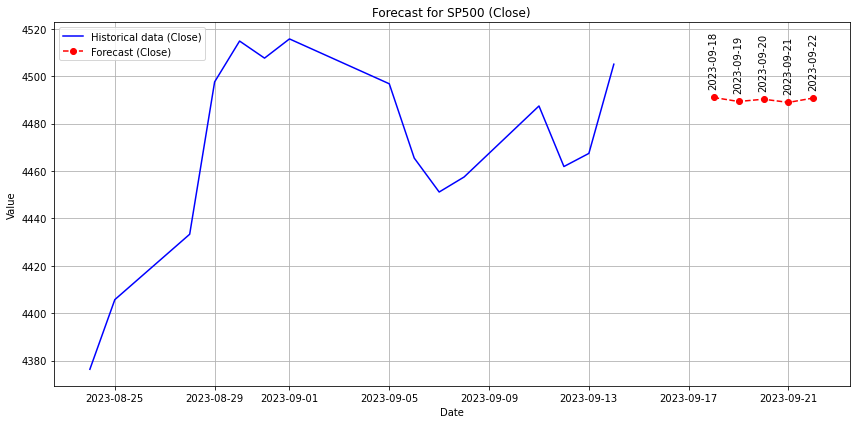

In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker_symbol = "^GSPC"
end_date = "2023-09-15"  

start_date = pd.to_datetime(end_date) - pd.DateOffset(days=21)

data = yf.download(ticker_symbol, start=start_date, end=end_date)

selected_features = data[["Close", "Volume"]]

last_21_days = selected_features.values

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

normalized_last_21_days = (last_21_days - data_mean) / data_std

forecast = best_model.predict(np.array([normalized_last_21_days]))

forecast_unscaled = []

for i in range(forecast.shape[1]):  
    single_day_forecast = forecast[0, i]  
    unscaled_forecast = single_day_forecast * data_std + data_mean
    forecast_unscaled.append(unscaled_forecast)


plt.figure(figsize=(12, 6))


plt.plot(data.index, selected_features["Close"], label="Historical data (Close)", color='blue')


forecast_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=3) 
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_unscaled)) 
plt.plot(forecast_dates, [item[0] for item in forecast_unscaled], 'ro--', label="Forecast (Close)")


for i, date in enumerate(forecast_dates):
    plt.annotate(date.strftime("%Y-%m-%d"), (date, forecast_unscaled[i][0]), textcoords="offset points", xytext=(0,10), ha='center', rotation='vertical')


plt.legend(loc='upper left')

plt.title("Forecast for SP500 (Close)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()

plt.show()